<a href="https://colab.research.google.com/github/DiogoGMelo/Netuno---machine-learning/blob/main/Netuno.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

 BIBLIOTECAS NECESSÁRIAS

In [3]:
import tensorflow as tf
from tensorflow import keras
from keras.models import Model
from keras.models import load_model
from keras.layers import Dense, GlobalAveragePooling2D, Dropout
from keras.applications import MobileNetV2
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.preprocessing import image
import matplotlib.pyplot as plt
import numpy as np
from google.colab import drive
import os


PREPARAR O DATASET

Aqui é linkado as imagens presentes no google drive, para que os dados fiquem em pastas no drive

In [4]:
drive.mount("/content/drive")
# Caminho do dataset no Google Drive
dataset_path = "/content/drive/My Drive/dataset"


Mounted at /content/drive


In [5]:
IMG_SIZE = (160, 160)  # MobileNetV2 espera imagens neste tamanho
BATCH_SIZE = 32

# Criando um gerador de imagens para normalizar os dados
datagen = ImageDataGenerator(rescale=1./255, validation_split=0.2)  # Separando 20% para validação

# Carregar os dados de treino
train_data = datagen.flow_from_directory(dataset_path,
                                         target_size=IMG_SIZE,
                                         batch_size=BATCH_SIZE,
                                         class_mode='binary',  # Classificação binária (é ou não o gato)
                                         subset='training')

# Carregar os dados de validação
val_data = datagen.flow_from_directory(dataset_path,
                                       target_size=IMG_SIZE,
                                       batch_size=BATCH_SIZE,
                                       class_mode='binary',
                                       subset='validation')


Found 277 images belonging to 2 classes.
Found 68 images belonging to 2 classes.


TESTE DAS IMAGENS

Somente um teste para verificar se realmente o path está correto para cada uma das pastas do drive

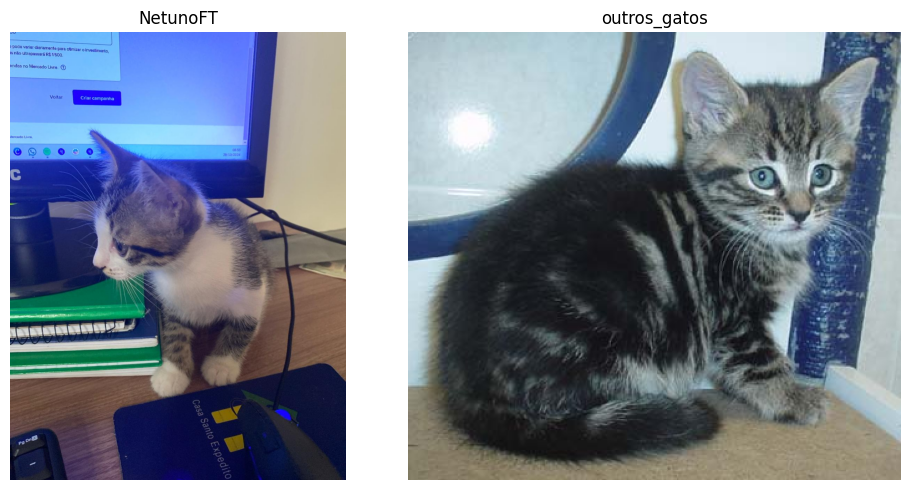

In [6]:
import random
import matplotlib.image as mpimg
# Obter uma foto aleatória de cada subpasta
classes = [subdir for subdir in os.listdir(dataset_path) if os.path.isdir(os.path.join(dataset_path, subdir))]
images_per_class = {}

for class_name in classes:
    class_path = os.path.join(dataset_path, class_name)
    # Selecionar uma imagem aleatória
    random_image = random.choice(os.listdir(class_path))
    images_per_class[class_name] = os.path.join(class_path, random_image)

# Plotar as imagens aleatórias
plt.figure(figsize=(10, 5))
for i, (class_name, image_path) in enumerate(images_per_class.items()):
    img = mpimg.imread(image_path)
    plt.subplot(1, len(images_per_class), i + 1)
    plt.imshow(img)
    plt.title(class_name)
    plt.axis('off')

plt.tight_layout()
plt.show()


CARREGANDO O MODELO

Usamos o modelo MobileNetV2, congelando todas suas camadas, menos as 20 ultimas.

In [8]:
# Carregar MobileNetV2 sem a camada de classificação final
base_model = MobileNetV2(input_shape=(160, 160, 3), include_top=False, weights="imagenet")

# Congelar as camadas do modelo base
base_model.trainable = False


9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [ ]:
for i, layer in enumerate(base_model.layers):
    print(i, layer.name, layer.trainable)


In [9]:
# Descongela todas as camadas superiores
base_model.trainable = True

# Congela apenas as camadas mais profundas
for layer in base_model.layers[:-20]:  # Descongela as últimas 20 camadas
    layer.trainable = False


In [ ]:
for i, layer in enumerate(base_model.layers):
    print(i, layer.name, layer.trainable)


CAMADAS PERSONALIZADAS

In [10]:
from keras.regularizers import l2 #tratar overfitting

x = base_model.output
x = GlobalAveragePooling2D()(x)  # Reduz a dimensionalidade das características extraídas
x = Dense(128, activation='relu', kernel_regularizer=l2(0.01))(x)  # Camada densa para aprendizado específico
x = Dropout(0.5)(x)  # overfitting
output = Dense(1, activation='sigmoid')(x)  # Saída binária: "é ou não é o gato específico"

# Criar o modelo final
model = Model(inputs=base_model.input, outputs=output)


COMPILAR

In [11]:
model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.0001),
              loss='binary_crossentropy',
              metrics=['accuracy'])

history = model.fit(train_data, epochs=10, validation_data=val_data)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 178s 19s/step - accuracy: 0.5459 - loss: 3.0464 - val_accuracy: 0.8529 - val_loss: 2.6753
Epoch 2/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 17s 2s/step - accuracy: 0.9223 - loss: 2.5433 - val_accuracy: 0.8824 - val_loss: 2.5659
Epoch 3/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 17s 2s/step - accuracy: 0.9678 - loss: 2.4104 - val_accuracy: 0.8824 - val_loss: 2.5128
Epoch 4/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 18s 2s/step - accuracy: 0.9927 - loss: 2.3131 - val_accuracy: 0.8824 - val_loss: 2.4729
Epoch 5/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 17s 2s/step - accuracy: 0.9993 - loss: 2.2608 - val_accuracy: 0.9118 - val_loss: 2.4238
Epoch 6/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 17s 2s/step - accuracy: 0.9944 - loss: 2.2175 - val_accuracy: 0.9118 - val_loss: 2.3821
Epoch 7/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 17s 2s/step - accuracy: 1.0000 - loss: 2.1688 - val_accuracy: 0.9265 - val_loss: 2.3444
Epoch 8/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 18s 2s/step - accuracy: 1.0000 - loss: 2.1340 - val_accuracy: 0.9265 - val_loss: 2.2938
Epoch 

AVALIAR O DESEMPENHO

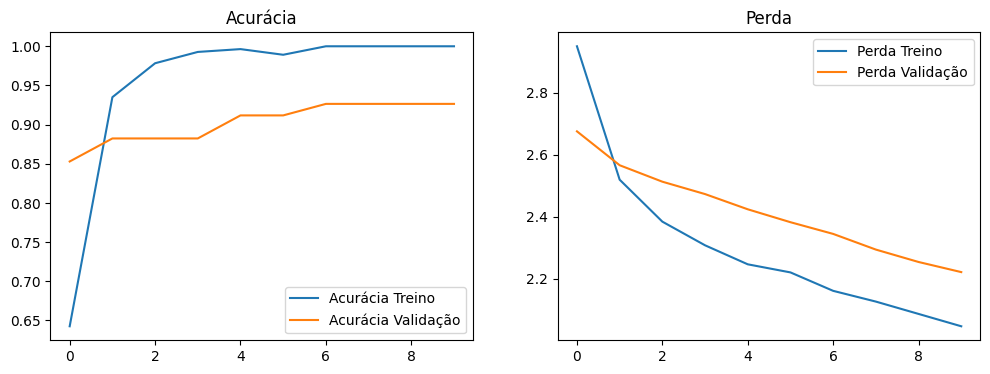

In [12]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(12, 4))

# Plotando a acurácia
plt.subplot(1, 2, 1)
plt.plot(acc, label='Acurácia Treino')
plt.plot(val_acc, label='Acurácia Validação')
plt.title('Acurácia')
plt.legend()

# Plotando a perda
plt.subplot(1, 2, 2)
plt.plot(loss, label='Perda Treino')
plt.plot(val_loss, label='Perda Validação')
plt.title('Perda')
plt.legend()

plt.show()


TESTE DO MODELO

Submetemos o modelo a testes de imagens de um novo dataset

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
Imagem: 3450.jpg, Probabilidade prevista: 0.9950
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
Imagem: 3458.jpg, Probabilidade prevista: 0.9988
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
Imagem: IMG-20250204-WA0026.jpg, Probabilidade prevista: 0.1365
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
Imagem: IMG-20250204-WA0018.jpg, Probabilidade prevista: 0.9540
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
Imagem: 3456.jpg, Probabilidade prevista: 0.9998


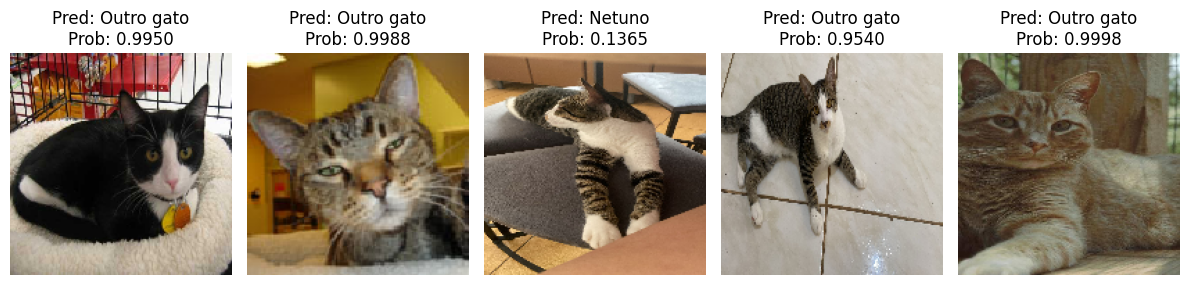

In [34]:
img_test_path = "/content/drive/My Drive/test_50%"

num_images = 5
image_files = os.listdir(img_test_path)
random_index = random.sample(os.listdir(img_test_path), num_images)
plt.figure(figsize=(12, 6))

for i, idx in enumerate(random_index):
    img_path = os.path.join(img_test_path, idx)

    img = keras.preprocessing.image.load_img(img_path, target_size=(160, 160))
    img_array = keras.preprocessing.image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0) / 255.0

    prediction = model.predict(img_array)
    prob = prediction[0][0]
    print(f"Imagem: {idx}, Probabilidade prevista: {prob:.4f}")
    predicted_label = "Netuno" if prob < 0.5 else "Outro gato"

    plt.subplot(1, num_images, i + 1)
    plt.imshow(img)
    plt.title(f"Pred: {predicted_label}\nProb: {prob:.4f}")
    plt.axis('off')

plt.tight_layout()
plt.show()

CONCLUSÃO

O desenvolvimento deste modelo de classificação binária utilizando MobileNetV2 foi um processo que trouxe aprendizados importantes sobre a organização do dataset e a interpretação das saídas da rede neural. O objetivo era classificar corretamente imagens entre a classe específica ("Netuno") e a ("Outro gato").

Ao longo do projeto, foi constatado que o comportamento padrão do método flow_from_directory influenciou na atribuição dos rótulos das classes com base na ordem alfabética das pastas, resultando na necessidade de ajustes na lógica de predição. A classe específica ("Netuno") foi reconhecida como um caso distinto, sendo associada a baixas probabilidades, enquanto as demais imagens ("Outro gato") foram identificadas com alta confiança.O
